<a href="https://colab.research.google.com/github/BaskaranV15/Transfer-Learning-for-binary-classification/blob/main/transfer_learning_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile


In [33]:
def train_val_datasets():
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='/content/horse-or-human.zip/',
        batch_size=32,
        image_size=(150,150),
        shuffle=True,
        seed=7
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='/content/validation-horse-or-human.zip',
        batch_size=32,
        image_size=(150,150),
        shuffle=True,
        seed=7
    )
    return training_dataset, validation_dataset


In [34]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(include_top = False, input_shape = (150, 150, 3), weights = None)
pre_trained_model.load_weights(local_weights_file)


In [35]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_470 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_470   │ (None, 74, 74, 32)     │             96 │ conv2d_470[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_470            │ (None, 74, 74, 32)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_471 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_470[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_471   │ (None, 72, 72, 32)     │             96 │ conv2d_471[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_471            │ (None, 72, 72, 32)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_472 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_471[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_472   │ (None, 72, 72, 64)     │            192 │ conv2d_472[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_472            │ (None, 72, 72, 64)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 35, 35, 64)     │              0 │ activation_472[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_473 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_473   │ (None, 35, 35, 80)     │            240 │ conv2d_473[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_473            │ (None, 35, 35, 80)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_474 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [36]:
for layer in pre_trained_model.layers:
    layers.trainable = False


In [37]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output


In [38]:
def create_final_model(pre_trained_model, last_output):
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  rotation_range = 0.4,
                                  shear_range = 0.1,
                                  zoom_range = 0.3,
                                  fill_mode = 'nearest'
                                  )

In [40]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.970:
            self.model.stop_training = True
            print("\nReached 97.0% accuracy so cancelling training!")


In [41]:
model = create_final_model(pre_trained_model, last_output)


In [42]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check both training accuracy and validation accuracy
        if logs.get('accuracy') > 0.970 and logs.get('val_accuracy') > 0.7--5:
            self.model.stop_training = True
            print("\nReached 97.0% accuracy on either training or validation so cancelling training!")


In [43]:
path_horse_or_human = '/content/horse-or-human.zip'
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = '/content/validation-horse-or-human.zip'



In [ ]:

local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

model.summary()

In [45]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [46]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  rotation_range = 0.4,
                                  shear_range = 0.1,
                                  zoom_range = 0.3,
                                  fill_mode = 'nearest'
                                  )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150, 150),
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   shuffle = True)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size =20,
                                                        class_mode = 'binary',
                                                        shuffle = False)


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [47]:
history = model.fit(train_generator,
    validation_data = validation_generator,
    epochs = 10,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 - 241s - 5s/step - accuracy: 0.8364 - loss: 0.4597 - val_accuracy: 0.9609 - val_loss: 0.1345
Epoch 2/10
52/52 - 216s - 4s/step - accuracy: 0.9659 - loss: 0.1917 - val_accuracy: 0.8555 - val_loss: 0.3146
Epoch 3/10
52/52 - 259s - 5s/step - accuracy: 0.9796 - loss: 0.0904 - val_accuracy: 0.7812 - val_loss: 0.6327
Epoch 4/10
52/52 - 263s - 5s/step - accuracy: 0.9864 - loss: 0.0609 - val_accuracy: 0.8047 - val_loss: 0.4944
Epoch 5/10
52/52 - 213s - 4s/step - accuracy: 0.9893 - loss: 0.0451 - val_accuracy: 0.7031 - val_loss: 0.9928
Epoch 6/10
52/52 - 214s - 4s/step - accuracy: 0.9883 - loss: 0.0354 - val_accuracy: 0.6875 - val_loss: 1.1078
Epoch 7/10
52/52 - 264s - 5s/step - accuracy: 0.9932 - loss: 0.0251 - val_accuracy: 0.7578 - val_loss: 0.7192
Epoch 8/10
52/52 - 218s - 4s/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.6914 - val_loss: 1.1836
Epoch 9/10
52/52 - 259s - 5s/step - accuracy: 0.9951 - loss: 0.0234 - val_accuracy: 0.7344 - val_loss: 0.9427
Epoch 10/10
52/52 - 2

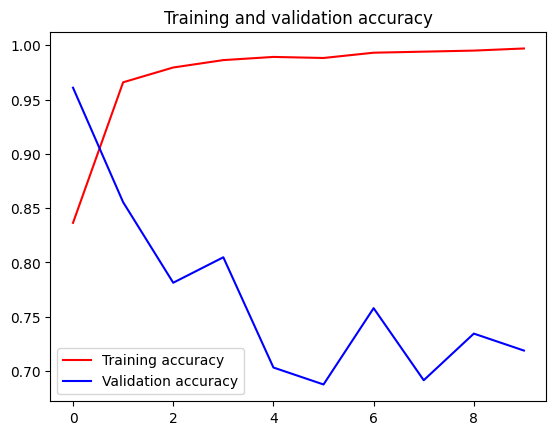

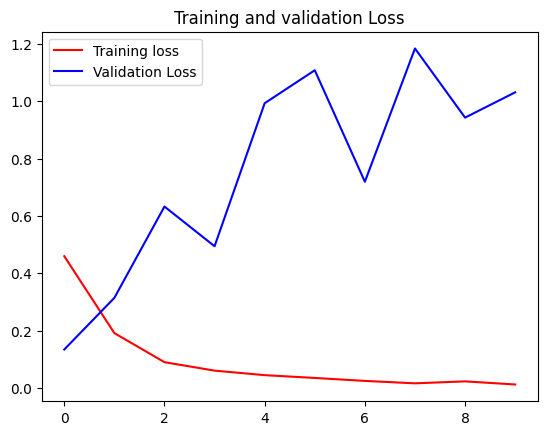

<Figure size 640x480 with 0 Axes>

In [48]:

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

[reference](https://chatgpt.com/share/671683e1-21cc-8003-aa3f-4c2c250877d8)